# 反信用卡欺诈模型

## 简介

交易欺诈作为信用卡行业面临的主要贷后风险业务问题，每年都使信用卡行业遭受巨额损失。基于大数据机器学习开发出高效的交易欺诈识别模型一直是金融行业的主要挑战之一。

本次建模的目标是识别交易是否欺诈，该数据集来源于Kaggle网站，一共包含284807条记录和25个变量，其中因变量Class表示用户在交易中是否发生欺诈行为（1表示欺诈交易，0表示正常交易）。数据集中只包含数值型变量。由于数据保密性问题，我们不能提供原始特征和数据上的更多背景信息，除‘Time’和‘Amount’外的其他变量都进行了PCA（主成分分析）变换，其中特征V1，V2，…,V28是由PCA得到的主成分。特征‘Time’表示交易时间间隔，‘Amount’是该笔交易的金额。

In [1]:
#读入训练集数据
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train=pd.read_csv('creditcard.csv')
train=train.copy()

In [2]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 特征工程

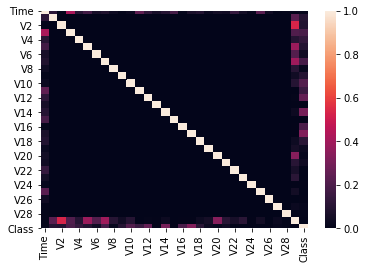

            Time            V1            V2            V3            V4  \
Time    1.000000  1.173963e-01  1.059333e-02  4.196182e-01  1.052602e-01   
V1      0.117396  1.000000e+00  4.697350e-17  1.424390e-15  1.755316e-17   
V2      0.010593  4.697350e-17  1.000000e+00  2.512175e-16  1.126388e-16   
V3      0.419618  1.424390e-15  2.512175e-16  1.000000e+00  3.416910e-16   
V4      0.105260  1.755316e-17  1.126388e-16  3.416910e-16  1.000000e+00   
V5      0.173072  6.391162e-17  2.039868e-16  1.436514e-15  1.940929e-15   
V6      0.063016  2.398071e-16  5.024680e-16  1.431581e-15  2.712659e-16   
V7      0.084714  1.991550e-15  3.966486e-16  2.168574e-15  1.556330e-16   
V8      0.036949  9.490675e-17  4.413984e-17  3.433113e-16  5.195643e-16   
V9      0.008660  2.169581e-16  5.728718e-17  4.233770e-16  3.859585e-16   
V10     0.030617  7.433820e-17  4.782388e-16  6.289267e-16  6.055490e-16   
V11     0.247689  2.438580e-16  9.468995e-16  5.501758e-17  2.083600e-16   
V12     0.12

In [3]:
#绘出各个特征之间相关系数
import seaborn as sns
corrmat=train.corr().abs()
sns.heatmap(corrmat)
plt.show()
print(corrmat)

由上表知道V2和Amount的相关性比较高，约为0.53。可以得出两个向量之间的共线性比较高，因此，我们去掉V2特征。

In [4]:
#我们去掉V2特征
del train['V2']

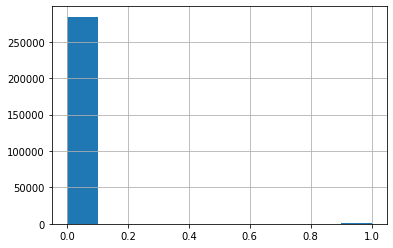

In [5]:
train['Class'].hist()

如上图所示，284807条信用卡交易中，欺诈交易仅占0.17%，两个类别的比例存在严重不平衡现象。建模之前，我们首先使用SMOTE算法转换为相对平衡的数据，代码如下：

In [6]:
#使用SMOTE将数据集转化为相对平衡的数据
from imblearn.over_sampling import SMOTE
from sklearn import model_selection

x=train.drop(['Time','Class'],axis=1)
y=train.Class

#将数据集拆分为训练集和测试集，其中测试集数占30%比重。
x_train,x_test,y_train,y_test=model_selection.train_test_split(x,y,test_size=0.3,random_state=1234)

over_samples=SMOTE(random_state=1234)
over_samples_x,over_samples_y=over_samples.fit_sample(x_train,y_train)



## 建模

接下来，利用重抽样的数据构建XGBoost模型。

In [7]:
#XGBoost来训练模型
import xgboost as xgb
import numpy as np

#XGBoost来训练训练集
xgb=xgb.XGBClassifier(learning_rate=0.1,n_estimators=140,max_depth=2,min_child_weight=2,gamma=0.5,subsample=0.8,
                                              colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
xgb.fit(over_samples_x,over_samples_y)

#XGBoost来预测测试集
fitted_labels=xgb.predict(x_test)

训练模型后，我们将评估所预测的训练集结果。我们使用四个指标：auc(曲线下面积），accuracy(准确率），precision(精准率）和recall(召回率）

0.9480919356858262
0.9882494762590265
0.11438784629133154
0.9078014184397163


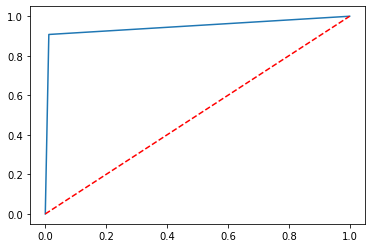

In [8]:
from sklearn.metrics import roc_curve,auc
#计算auc
fpr,tpr,thresholds =roc_curve(y_test,fitted_labels)
auc=auc(fpr,tpr)
print(auc)

#以fpr假正率为横轴，tpr真征率为纵轴绘出auc曲线
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

from sklearn.metrics import accuracy_score,precision_score,recall_score
#计算accuracy
accuracy = accuracy_score(y_test,fitted_labels)
print(accuracy)
#计算precision
precision =precision_score(y_test,fitted_labels)
print(precision)
#计算recall
recall=recall_score(y_test,fitted_labels)
print(recall)

## 结论

通过XGboost模型的参数调优，我们将auc值从0.917左右优化到了0.948。